# pix2pix with least-squares gan

https://arxiv.org/pdf/1611.04076v2.pdf

In [1]:
import tensorflow as tf
from tensorflow.contrib import layers
import numpy as np
from nbutil import imshow_multi
import skimage
import skimage.io
import os

In [2]:
BATCH_SIZE = 4
IMAGE_SIZE = 600 # source and target images are tiled horizontally when they're loaded, so they're initially [IMAGE_SIZE, IMAGE_SIZE*2]
CROPPED_SIZE = 400
RESIZE_TO = 128
ENCODER_LAYERS = [64, 64, 128, 128, 128, 256, 256] # 128x128 / 2^7 = 1x1
# ENCODER_LAYERS = [64, 64, 128, 128] # 1x1
DISC_TILE_SIZE = 32
DISC_LAYERS = [32, 64, 128, 256, 256]

encoder_conv_init = tf.truncated_normal_initializer(0.0, 0.02)
decoder_conv_init = tf.truncated_normal_initializer(0.0, 0.02)
disc_conv_init = tf.truncated_normal_initializer(0.0, 0.02)
biases_initializer = tf.truncated_normal_initializer(0.02, 0.0)

N_DISC_PATCHES = 1 # for each image, we take N random patches and run them thru the discriminator

L1_WEIGHT = 100 # how much is L1 loss weighted, vs discriminator loss?

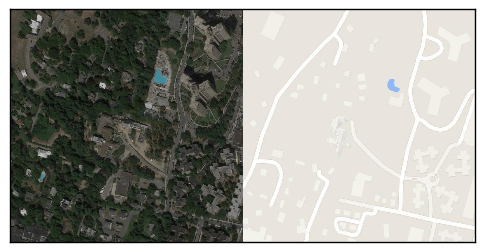

(600, 1200, 3)


In [3]:
%matplotlib inline

def load_image(path):
    # load image
    img = skimage.io.imread(path)
    img = img[:,:,:3] # drop alpha channel
    return img / 255.0

image = load_image('../data/maps/train/100.jpg')
imshow_multi([image])

print image.shape


In [4]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

dir = '../data/maps/train'
image_names = [os.path.join(dir, name) for name in os.listdir(dir) if name.endswith('.jpg')]

def create_qs(image_names):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    filename_q = tf.train.slice_input_producer([filename_tensor], num_epochs=None, shuffle=True)[0]

    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.cast(image_255, tf.float32) / 255.0 # images are 1200x600x3
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE*2, 3])
    source = tf.slice(image, [0, 0, 0], [-1, IMAGE_SIZE, -1])
    target = tf.slice(image, [0, IMAGE_SIZE, 0], [-1, IMAGE_SIZE, -1])
    # combine source and target into the same image with 6 channels:
    combined = tf.concat([source, target], axis=2)
    cropped = tf.random_crop(combined, [CROPPED_SIZE, CROPPED_SIZE, 6])
    # separate them:
    source = tf.slice(cropped, [0, 0, 0], [CROPPED_SIZE, CROPPED_SIZE, 3])
    target = tf.slice(cropped, [0, 0, 3], [CROPPED_SIZE, CROPPED_SIZE, 3])

    source_batch, target_batch = tf.train.shuffle_batch([source, target], batch_size=BATCH_SIZE, capacity=512, min_after_dequeue=256)
    
    source_batch = tf.image.resize_bilinear(source_batch, [RESIZE_TO, RESIZE_TO])
    target_batch = tf.image.resize_bilinear(target_batch, [RESIZE_TO, RESIZE_TO])
    
    return source_batch, target_batch

source_batch, target_batch = create_qs(image_names)


In [5]:
session = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-14, started daemon 140196246972160)>,
 <Thread(Thread-15, started daemon 140196238579456)>]

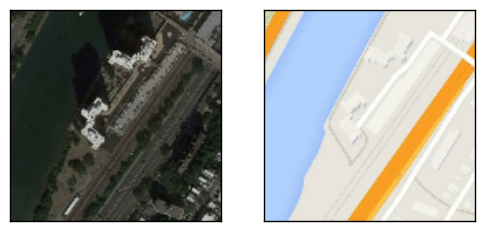

In [6]:
%matplotlib inline

srcs_, tgts_ = session.run([source_batch, target_batch])
imshow_multi([srcs_[0], tgts_[0]])

In [7]:
def lrelu(x):
    # leaky relu
    alpha = 0.1
    return tf.maximum(alpha*x,x)

def identity(x): return x


In [8]:
def hw(tensor): return (tensor.shape[1].value, tensor.shape[2].value)

def create_unet(image, name='unet'):
    with tf.variable_scope(name):
        downscaled_images = {}
        ksize = 4
        for i, n_channels in enumerate(ENCODER_LAYERS):
            downscaled_images[hw(image)] = image
            image = layers.conv2d(image, 
                                  n_channels, 
                                  scope='encode_'+str(i), 
                                  kernel_size=ksize, 
                                  activation_fn=lrelu,
                                  normalizer_fn=layers.batch_norm, 
                                  # biases_initializer=biases_initializer,
                                  stride=2,
                                  weights_initializer=encoder_conv_init)            
        for i, n_channels in enumerate(list(reversed(ENCODER_LAYERS[:-1])) + [32]):
            image = layers.conv2d_transpose(image, 
                                            n_channels, 
                                            scope='decode_'+str(i), 
                                            kernel_size=ksize, 
                                            activation_fn=lrelu, 
                                            normalizer_fn=layers.batch_norm,
                                            # biases_initializer=biases_initializer,
                                            stride=2,
                                            weights_initializer=decoder_conv_init)
            if hw(image) in downscaled_images:
                u_layer = downscaled_images[hw(image)]
                image = tf.concat([image, u_layer], axis=3)
        image = layers.conv2d(image, 32, kernel_size=1, scope='color1', activation_fn=lrelu)
        image = layers.conv2d(image, 3, kernel_size=1, scope='color2', activation_fn=identity)
        # return tf.nn.tanh(image)
        return image

def create_disc(image, name='disc', reuse=False):
    # output 1 if real, -1 if fake
    # the discriminator should take in 6-channel images -- the generated image and the source image, concatenated
    with tf.variable_scope(name, reuse=reuse):
        ksize = 5
        image = layers.conv2d(image, 32, scope='disc0', kernel_size=3, activation_fn=lrelu)
        for i, n_channels in enumerate(DISC_LAYERS):
            image = layers.conv2d(image,
                                  n_channels, 
                                  scope='disc_'+str(i), 
                                  kernel_size=ksize, 
                                  activation_fn=lrelu, 
                                  stride=2,
                                  # biases_initializer=biases_initializer,
                                  normalizer_fn=layers.batch_norm, 
                                  weights_initializer=disc_conv_init)
        fc1 = layers.flatten(image)
        fc1 = layers.fully_connected(fc1, 16, activation_fn=lrelu, scope='fc1', biases_initializer=biases_initializer)
        fc2 = layers.fully_connected(fc1, 1, scope='fc2', activation_fn=identity)
        return tf.reshape(fc2, [-1])

def create_disc_outputs(gen_source, gen_output, real_source, real_output):
    real = tf.concat([gen_source, gen_output], axis=3)
    gen = tf.concat([real_source, real_output], axis=3)
    
    def random_crop_across_batches(images):
        return tf.map_fn(lambda img: tf.random_crop(img, [DISC_TILE_SIZE, DISC_TILE_SIZE, 6]), images)
    
    real_crops = random_crop_across_batches(tf.tile(real, [N_DISC_PATCHES, 1, 1, 1]))
    gen_crops = random_crop_across_batches(tf.tile(gen, [N_DISC_PATCHES, 1, 1, 1]))
    # real_crops = real
    # gen_crops = gen
    
    real_output = create_disc(real_crops)
    fake_output = create_disc(gen_crops, reuse=True)
    return real_output, fake_output

def least_squares_loss(outputs, targets):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(targets, outputs))))

# def l1_loss(outputs, targets):
#     return tf.abs(outputs - targets)

scope = 'pix38'
with tf.variable_scope(scope):
    gen_lr = tf.placeholder_with_default(tf.constant(0.01), [], name='gen_lr')
    disc_lr = tf.placeholder_with_default(tf.constant(0.001), [], name='disc_lr')
    
    generated_batch = create_unet(source_batch)
    
    real_disc_scores, fake_disc_scores = create_disc_outputs(source_batch, generated_batch, source_batch, target_batch)
    l1_loss = tf.reduce_mean(tf.abs(generated_batch - target_batch))
    
    reals_are_real_loss = least_squares_loss(tf.ones_like(real_disc_scores), real_disc_scores)
    fakes_are_fake_loss = least_squares_loss(tf.ones_like(fake_disc_scores) * -1, fake_disc_scores)
    fakes_are_real_loss = least_squares_loss(tf.ones_like(fake_disc_scores), fake_disc_scores)
    
    gen_loss = l1_loss * L1_WEIGHT + fakes_are_real_loss
    disc_loss = reals_are_real_loss + fakes_are_fake_loss
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope+'/disc')
    train_disc = tf.train.RMSPropOptimizer(disc_lr).minimize(disc_loss, var_list=disc_vars, global_step=global_step)
    
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope+'/unet')
    train_gen = tf.train.RMSPropOptimizer(gen_lr).minimize(gen_loss, var_list=gen_vars)
    
    examples = tf.concat([source_batch, target_batch, generated_batch], axis=2)

print 'built graph'

built graph


In [9]:
session = None
saver = None
save_path = None

def create_session():
    global session
    global saver
    global save_path
    
    if session: session.close()
    
    session = tf.InteractiveSession()

    save_path = None # 'models/pix2pix-sat2map-4'
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    session.run(init_op)
    tf.train.start_queue_runners(sess=session)

    import os
    saver = None
    if save_path:
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(save_path)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
            print 'Restored from checkpoint', ckpt.model_checkpoint_path
        else:
            print 'Did not restore from checkpoint'
    else:
        print 'Will not save progress'

create_session()

Will not save progress


In [22]:
def avg(x): return sum(x) / float(len(x))

disc_losses = []
gen_losses = []

while True:
    examples_ = None
    step_ = global_step.eval()
    
    # for _ in xrange(50 if step_ < 25 or step_ % 500 == 0 else 5):
    feed = {
        disc_lr: 0.001,
        gen_lr: 0.01
    }
    disc_loss_, _, gen_loss_, _ = session.run([disc_loss, train_disc, gen_loss, train_gen], feed_dict=feed)
    disc_losses.append(disc_loss_)
    # gen_loss_, _ = session.run([gen_loss, train_gen], feed_dict=feed)
    gen_losses.append(gen_loss_)
    
    if step_ % 50 == 0:
        print "Step: {}, disc loss: {}, gen loss: {}".format(step_, avg(disc_losses), avg(gen_losses))
        disc_losses = []
        gen_losses = []
            
        examples_ = session.run(examples[:1])
        
        if step_ % 600 == 0:
            imshow_multi(list(examples_))
        
        if step_ % 200 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_)
                print 'Saved'


Step: 7900, disc loss: 0.166797677407, gen loss: 5.89790382256


KeyboardInterrupt: 

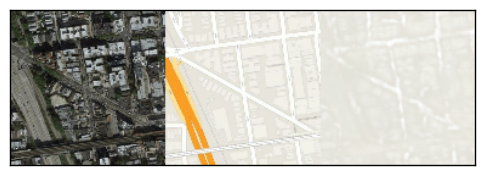

In [21]:
examples_ = session.run(examples[:1])
imshow_multi(list(examples_))

In [ ]:
session.run([real_disc_scores[0], fake_disc_scores[0]])